# fig4paper 

## Configuration 

In [1]:
%precision 4
%load_ext autoreload
%autoreload 2
%load_ext version_information
from IPython.display import display
%matplotlib inline

In [2]:
%version_information numpy, scipy, matplotlib

Software versions
Python 3.6.4 64bit [MSC v.1900 64 bit (AMD64)]
IPython 6.2.1
OS Windows 10 10.0.17134 SP0
numpy 1.14.0
scipy 1.0.0
matplotlib 2.1.2
Wed Aug 01 14:40:28 2018 ???? (?W???)

In [3]:
from imp import reload
import sys
from os import path
import numpy as np
import scipy as sp
from scipy import linalg, arccos
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d

In [4]:
import lib.Lode as ode
import lib.Ldata as dm
import lib.Ldraw as vis

C:\Users\ryoikota\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
%run conf_fig

In [6]:
mpl.rcParams.update(style)

## Data

In [7]:
sdata = dm.loadData(path.join('data','s_orbit.hdf5'))
lmdata = dm.loadData(path.join('data','lm_orbit.hdf5'))

In [8]:
tarray=lmdata['tarray']
dt = tarray[1] - tarray[0]

nfold = len(lmdata['xyz'])

evecA = lmdata['eigVecDF']
evalA = lmdata['eigValDF']
evalB = sp.real(lmdata['eigValSymDF'])
evecB = lmdata['eigVecSymDF']

param = lmdata['param']

orbits = lmdata['xyz']
ref = np.copy(orbits[0,:,:])
xyz = np.copy(ref)

ref = ref[np.newaxis]
perturbed = np.copy(orbits[1:,:,:])
diff = perturbed - ref
diffsq = diff**2
_h = np.sum(diffsq, axis=-1)
normDiff = np.sqrt(_h)

DevecB = evecB[1:] - evecB[:-1]

In [9]:
upto1h = slice(0,301)
upto3 = slice(0,601)
upto6 = slice(0,1201)

In [10]:
evecAp = evecA[upto1h]

v1 = sp.real(evecAp[:,0])
v2 = sp.imag(evecAp[:,0])
v3 = sp.real(evecAp[:,2])

In [11]:
P = sp.stack([v1, v2, v3], axis=-1)

Pinv = []
for _P in P:
    Pinv.append(sp.linalg.inv(_P))
Pinv = np.array(Pinv)

diff1h = diff[:,upto1h,:]

nrmPhi3 = []
nrmPhi12 = []
for _dev, _P, _Pinv in zip(diff1h[0], P, Pinv):
    y1, y2, y3 = _Pinv @ _dev
    phi3 = _P @ [0, 0., y3]
    phi12 = _P @ [y1, y2, 0.0]
    nrmPhi3.append(linalg.norm(phi3))
    nrmPhi12.append(linalg.norm(phi12))

## Figures

In [12]:
Figs = []

### Fig. trajectories

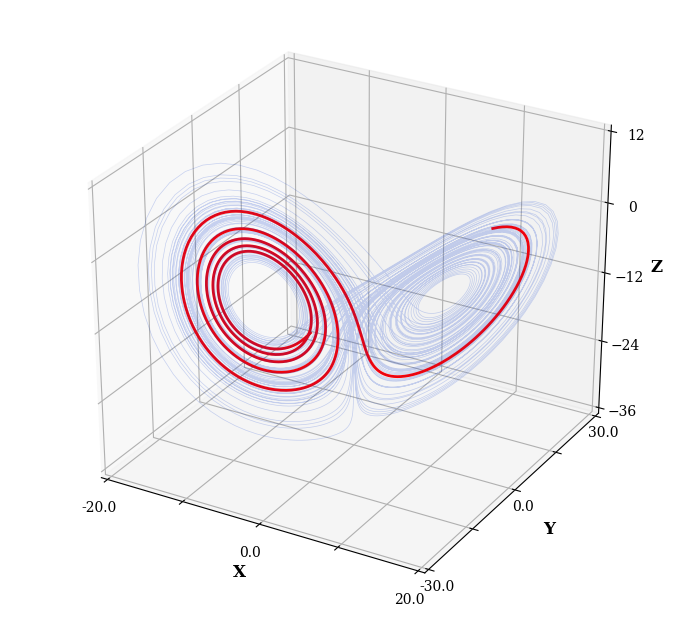

In [13]:
frameOne = vis.LFrame(sdata,
                    figsize=(width_1col, 1.2*width_1col),
                    dpi=100
                   )

gsOne = gridspec.GridSpec(1,1)

#tpane = vis.PaneTime(frameOne, gsOne[4])
p3pane = vis.PanePhase3D(frameOne, gsOne[0], **p3attr)
p3pane.setBG(**bgprop)

p3pane.set_line_prop([p3line_prop])
p3pane.set_line_prop([{'marker': '', 'markersize': 0.0}])
p3pane.plotTrail([0.0, 4.0])
p3pane.ax.xaxis.set_tick_params(pad=3)
p3pane.ax.yaxis.set_tick_params(pad=-2)

gsOne.tight_layout(frameOne.fig)

In [14]:
Figs.append((frameOne.fig,'figOne.pdf'))

### Ensemble 

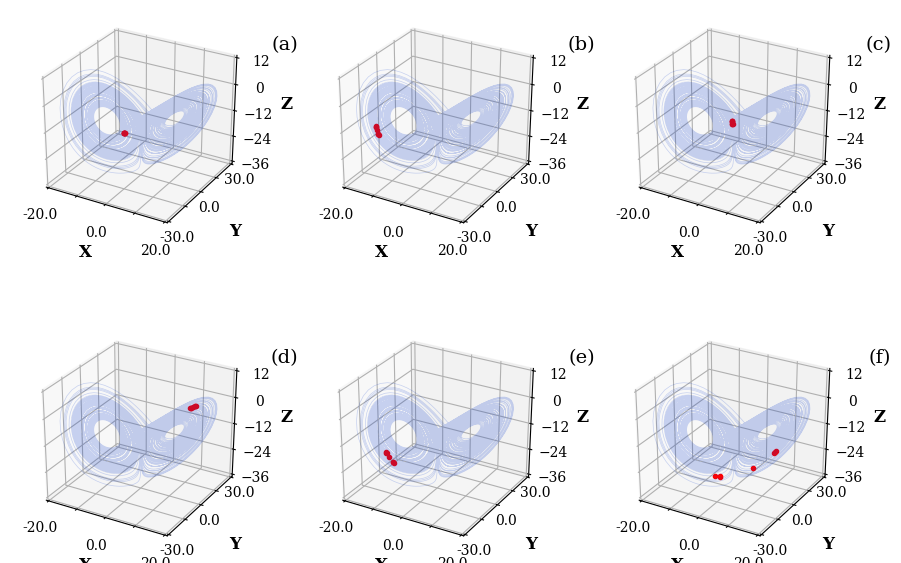

In [15]:
frameMul = vis.LFrame(lmdata,
                    figsize=(1.4*width_1col, width_1col),
                    dpi=100
                   )

gsMul = gridspec.GridSpec(2,3)
gsMulArray = [gsMul[i,j] for i in range(2) for j in range(3)]

panes = []
for gs in gsMulArray:
    p = vis.PanePhase3DM(frameMul, gs, **p3attr)
    p.ax.xaxis.set_tick_params(pad=3)
    p.ax.yaxis.set_tick_params(pad=-2)
    panes.append(p)

tsnaps = [0.0, 3.1, 3.4, 4.0, 4.6, 5.4]
annos = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for p,t,a in zip(panes, tsnaps, annos):
    p.setBG(**bgprop)
    p.set_line_prop([p3line_prop]*nfold)
    p.set_line_prop([{'marker': 'o', 'markersize': 3.0}]*nfold)
    p.plotSnap(t)
    p.set_label(a, (1.15, 0.9))
    p._label.set_fontsize(14)

gsMul.tight_layout(frameMul.fig, 
                   pad=3.0,
                   rect=[0., 0., 0.95, 1.0]
                  )

In [16]:
Figs.append((frameMul.fig,path.join('..','figs','figMul.pdf')))

### Eigenvalue B

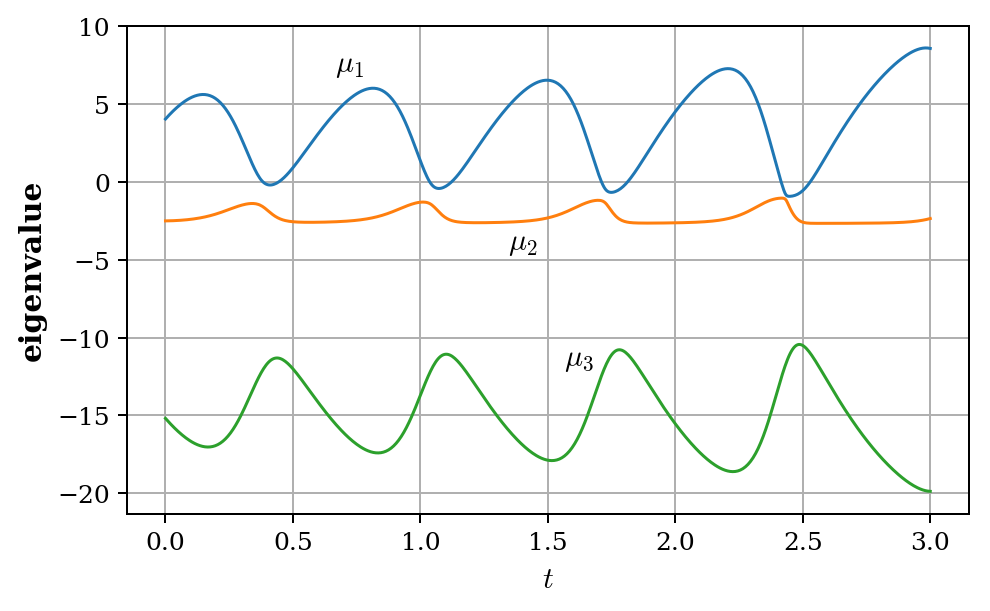

In [17]:
figEigSym = plt.figure(figsize=(0.8*width_1col, 0.5*width_1col),
                      dpi=180
                      )
gsEigSym = gridspec.GridSpec(1,1)
axEigSym = figEigSym.add_subplot(gsEigSym[0])

for i in range(3):
    axEigSym.plot(tarray[upto3], np.real(evalB[upto3,i]))

axEigSym.set_xlabel(r'$t$')
axEigSym.set_ylabel('eigenvalue')

for i,tidx,label,va, offset in zip(
                    [0,1,2],
                    [160,280,340],
                    [r'$\mu_1$', r'$\mu_2$', r'$\mu_3$'],
                    ['bottom', 'top', 'bottom'],
                    [(-8,4), (0,-3),(-8,4)]):
    axEigSym.annotate(label,
                     xy=(tarray[tidx], np.real(evalB[tidx,i])),
                    xycoords='data',
                    xytext=offset,
                    textcoords='offset points',
                    va=va,
                    ha="center",
                    fontsize=12)
axEigSym.grid(True)
gsEigSym.tight_layout(figEigSym)

In [18]:
Figs.append((figEigSym,'figEigSym.pdf'))

### Fig Norm 

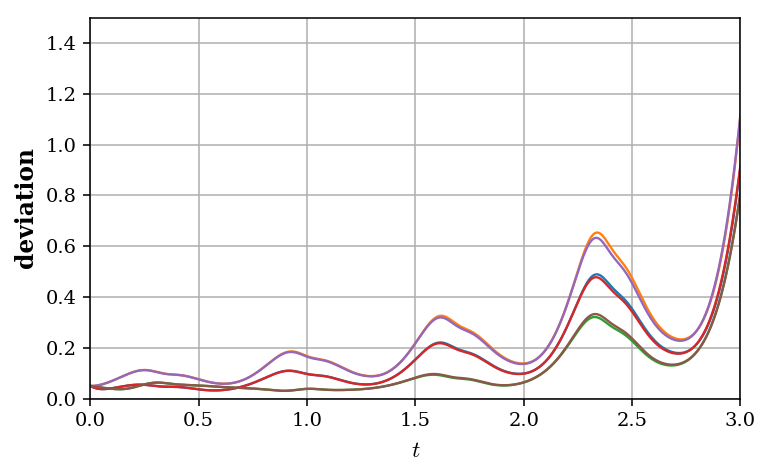

In [19]:
figNormDiff = plt.figure(figsize=(0.8*width_1col, 0.5*width_1col),
                        dpi = 140
                        )
gsNormDiff = gridspec.GridSpec(1,1)

ax1 = figNormDiff.add_subplot(gsNormDiff[0])

for _diff in normDiff:
    diff = _diff[upto3]
    ax1.plot(tarray[upto3], diff)
    



ax1.set_ylim([0., 1.5])
ax1.set_xlim([0., 3.])
ax1.set_xlabel(r'$t$')
ax1.set_ylabel('deviation')
ax1.grid(True)
gsNormDiff.tight_layout(figNormDiff)

In [20]:
Figs.append((figNormDiff,'figNormDiff.pdf'))

### Eigenvalues

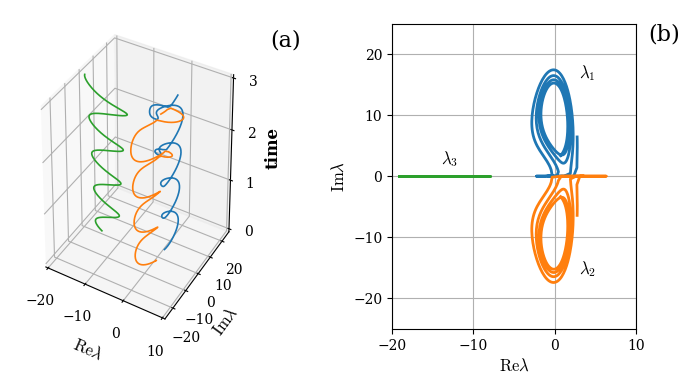

In [21]:
figEigA = plt.figure(figsize=(width_1col, 0.8*width_1col), 
                     dpi=100)
gsEigA = gridspec.GridSpec(1,2)
axEig3D = figEigA.add_subplot(gsEigA[0], projection='3d')
axEig2D = figEigA.add_subplot(gsEigA[1])

axEig3D.set_xlim((-20,10))
axEig3D.set_ylim((-25,25))
axEig2D.set_xlim((-20,10))
axEig2D.set_ylim((-25,25))

for i in range(3):
    axEig3D.plot(np.real(evalA[upto3,i]), 
                 np.imag(evalA[upto3,i]),
                 tarray[upto3])
    axEig2D.plot(np.real(evalA[upto3, i]), 
                 np.imag(evalA[upto3,i]),
                 lw=2.0)

axEig3D.set_aspect(0.8)
axEig2D.set_aspect(0.75)
axEig2D.grid(True)

axEig2D.set_xlabel(r'$\mathrm{Re} \lambda$')
axEig2D.set_ylabel(r'$\mathrm{Im} \lambda$')

axEig3D.set_xlabel(r'$\mathrm{Re} \lambda$')
axEig3D.set_ylabel(r'$\mathrm{Im} \lambda$')
axEig3D.set_zlabel('time', rotation=90)

axEig3D.annotate('(a)',
                (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16);

axEig2D.annotate('(b)',
                (1.05,1),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16);
for label,xy in zip([r'$\lambda_{0:d}$'.format(i) 
                  for i in range(1,4)],
                   [(3.0,16.0),(3.0,-16.0),(-14,2)]):
    axEig2D.annotate(label,
                    xy=xy,
                    xycoords='data',
                    fontsize=12)
gsEigA.tight_layout(figEigA,
                   w_pad=5.0,
                   rect=(0,0,0.95,1.0))

In [22]:
Figs.append((figEigA,'figEigA.pdf'))

### Fig Dev

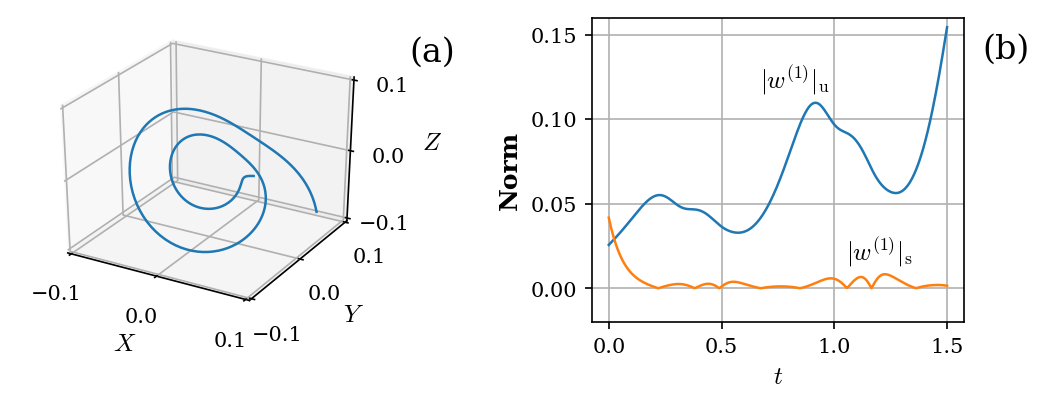

In [23]:
figDev = plt.figure(figsize=(width_1col, 
                             0.8*width_1col),
                    dpi=150
                   )

gsDev = gridspec.GridSpec(1,2)

axDev3D = figDev.add_subplot(gsDev[0], projection='3d')
axDev2D = figDev.add_subplot(gsDev[1])

axDev3D.set_xlim((-0.1,0.1))
axDev3D.set_ylim((-0.1, 0.1))
axDev3D.set_zlim((-0.1, 0.1))
axDev3D.set_aspect(0.8)
axDev3D.set_xticks((-0.1,0.,0.1))
axDev3D.set_yticks((-0.1,0.,0.1))
axDev3D.set_zticks((-0.1,0.0,0.1))
axDev3D.set_xlabel(r'$X$')
axDev3D.set_ylabel(r'$Y$')
axDev3D.set_zlabel(r'$Z$')
x,y,z = diff1h[0].T
axDev3D.plot(x,y,z)
axDev3D.annotate('(a)',
                (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16);
axDev2D.set_aspect(7.5)
axDev2D.plot(tarray[upto1h], nrmPhi12)
axDev2D.plot(tarray[upto1h], nrmPhi3)
axDev2D.set_ylim([-0.02,0.16])
axDev2D.set_yticks([0.0,0.05,0.1,0.15])
axDev2D.grid(True)
axDev2D.set_xlabel(r'$t$')
axDev2D.set_ylabel('Norm')
axDev2D.annotate('(b)',
                (1.05,0.95),
                xycoords='axes fraction',
                va="top",
                ha="left",
                fontsize=16);
axDev2D.annotate(r'$|w^{(1)}|_\mathrm{u}$',
                 xy=(tarray[180], nrmPhi12[180]),
                xycoords='data',
                xytext=(-8,4),
                textcoords='offset points',
                va="bottom",
                ha="center",
                fontsize=12)
axDev2D.annotate(r'$|w^{(1)}|_\mathrm{s}$',
                 xy=(tarray[240], nrmPhi3[240]),
                xycoords='data',
                xytext=(0, 4),
                textcoords='offset points',
                va="bottom",
                ha="center",
                fontsize=12)
gsDev.tight_layout(figDev, 
                  w_pad=5.0,
                  rect=(0.,0.,0.95,1.0)
                  )

In [24]:
Figs.append((figDev,'figDev.pdf'))

In [25]:
for f,fn in Figs:
    f.savefig(path.join('..','figs',fn))